In [1]:
#Importing required libraries
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt
from imutils import contours
import os
from array import *
from random import shuffle
import numpy as np
import cv2
import imutils
from imutils.perspective import four_point_transform
from imutils import contours
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
# Function to convert image to a 28X28 pixels
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt

def imageprepare(im):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    #im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))  # creates white canvas of 28x28 pixels

    if width > height:  # check which dimension is bigger
        # Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
        if (nheight == 0):  # rare case but minimum is 1 pixel
            nheight = 1
            # resize and sharpen
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
        newImage.paste(img, (4, wtop))  # paste resized image on white canvas
    else:
        # Height is bigger. Heigth becomes 20 pixels.
        nwidth = int(round((20.0 / height * width), 0))  # resize width according to ratio height
        if (nwidth == 0):  # rare case but minimum is 1 pixel
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
        newImage.paste(img, (wleft, 4))  # paste resized image on white canvas

    # newImage.save("sample.png

    tv = list(newImage.getdata())  # get pixel values

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) for x in tv]
#    print(tva)
    return np.array(tva)

In [3]:
#Function to sort image contours from left to right. This is essential to identify the ordering of digits in the score.
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
 
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
 
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
 
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
 
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)

In [4]:
#Display a 1 dimentional array of pixel colors as an image
def display(img):
    #plt.title('Example %d. Label: %d' % (i, test_labels[i]))
    plt.imshow(img.reshape((28,28)), cmap=plt.cm.gray_r)
    plt.show()

In [5]:
#Accuracy of image detection
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [6]:
#BAtch conversion of original images to a 28x28 image suitable for Mnist dataset

def ToMnistSize(img_list):
    #MnistImages = np.zeros((3,784))
    MnistImages=[]
    for i,im in enumerate(img_list):
        MnistImages.append(imageprepare(Image.fromarray(im)))
        #MnistImages.append(imageprepare(Image.fromarray(im)))
    return np.array(MnistImages)  


In [49]:
#Function to extract individual digits from the scorecard. It uses contour detection technique to identify digit contours
def findDigits(im):
    im = imutils.resize(im, height=200)
    thresh = cv2.threshold(im, 0, 255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[1]
    digitCnts = []

    # loop over the digit area candidates
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        if w >30 and h >= 10:
            digitCnts.append(c)
            
    
    cnts_sorted,_= contours.sort_contours(digitCnts,method="left-to-right")
    digits = []
    for c in cnts_sorted:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        current_digit = four_point_transform(im, box.reshape(4, 2))
        #current_digit=np.array(Image.fromarray(current_digit).resize((28, 28), Image.ANTIALIAS))
        im_box = cv2.drawContours(im,[box],0,(255,0,0),3)
        img_with_contours = cv2.drawContours(im,[box],0,(255,0,0),3)
        #current_digit=np.float32((current_digit>0.5)*1.0)
        digits.append(cv2.bitwise_not(current_digit))
        Image.fromarray(im_box)
    return np.array(digits), img_with_contours



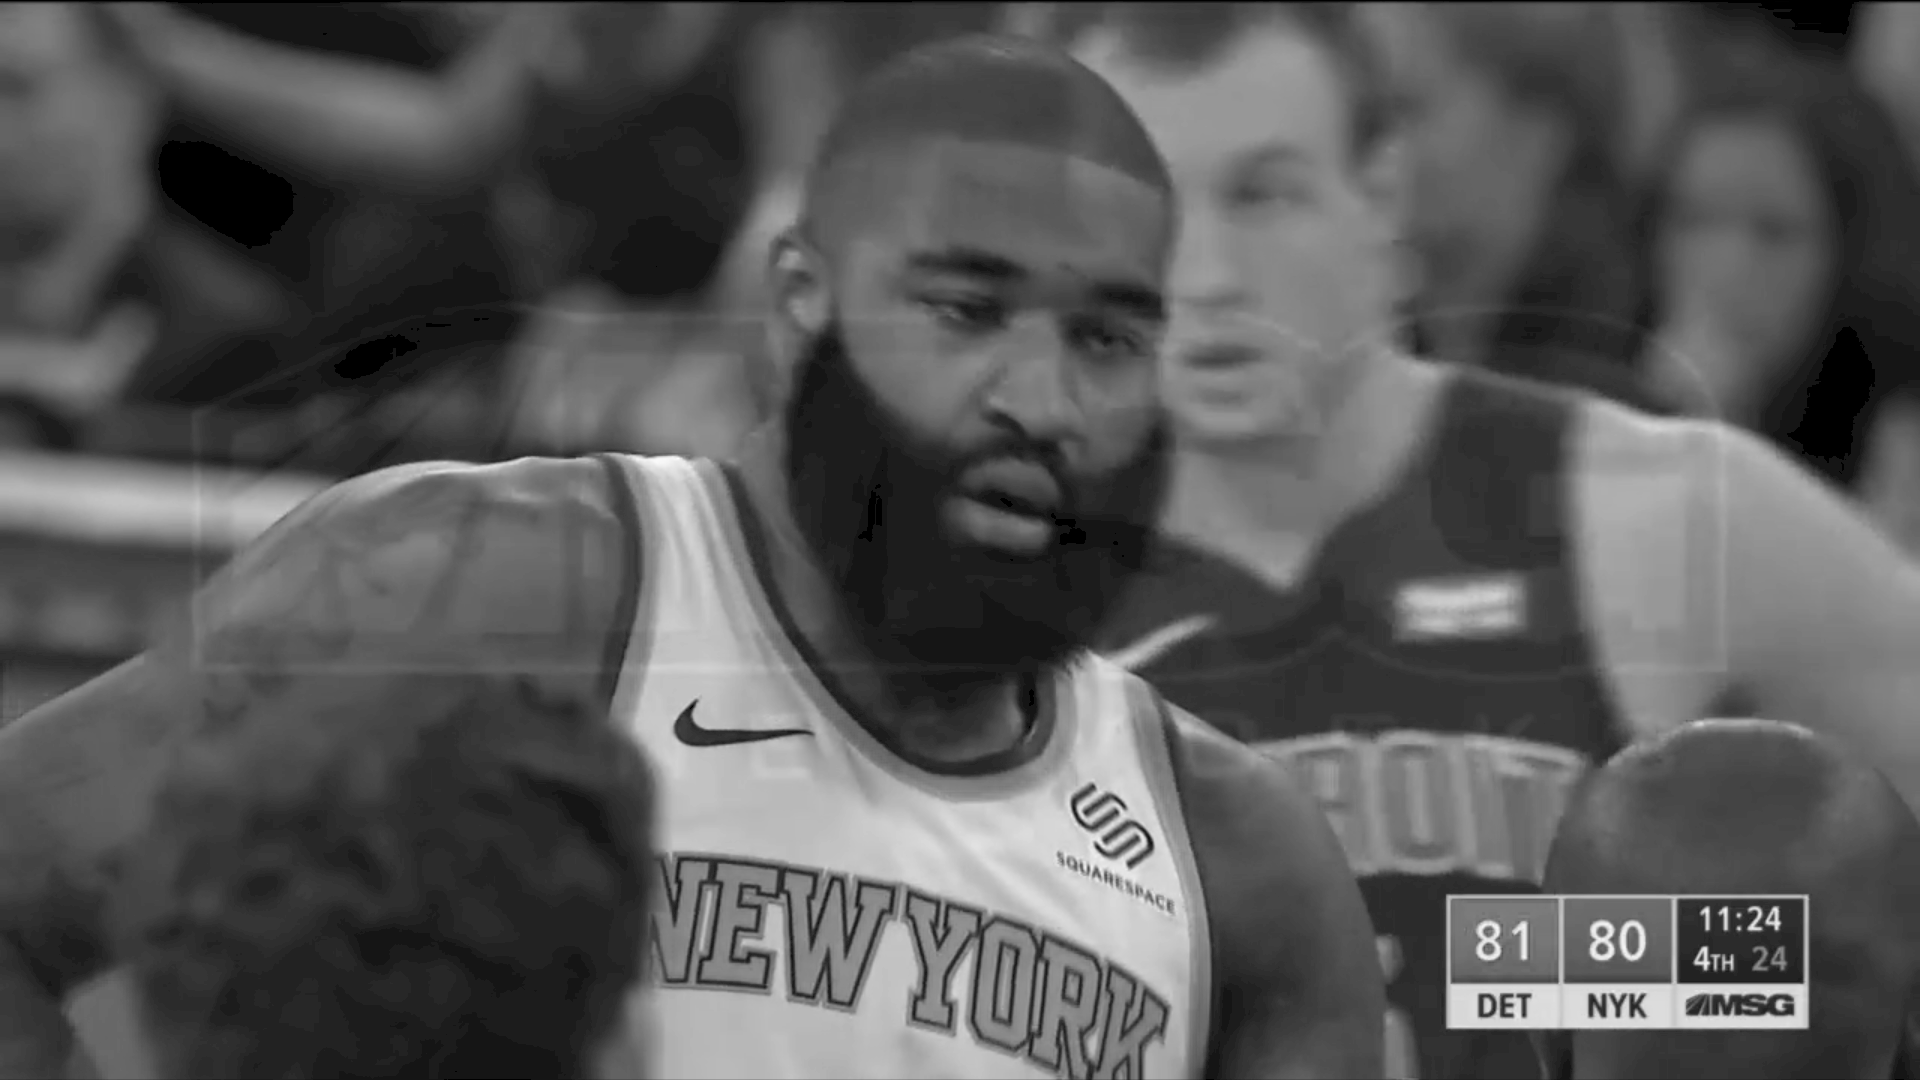

In [31]:
# load the example image
image = cv2.imread("Scores/Game1.png",0)
Image.fromarray(image)

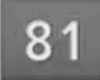

In [54]:
# Extracting scores card from the complete image

score1 = image[900:980,1450:1550] 
score2 = image[900:980,1570:1670] 

Image.fromarray(score1)


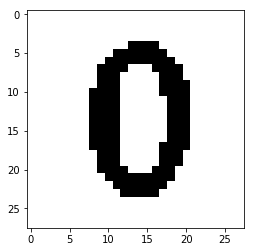

In [58]:
#Detecting individual digits from the scorecard. Function 'findDigits' detects the contours and extracts digits. 
#Each iamge is converted into a 1 dimensional vector of size 784 (28X28)

score1_digits,test1 = findDigits(score1)
score2_digits,test2 = findDigits(score2)

#score1_digits_final = (score1_digits.reshape(-1,784)>150)*255
#score2_digits_final = (score2_digits.reshape(-1,784)>150)*255


#score1_digits_final = ToMnistSize(score1_digits)
#score2_digits_final = ToMnistSize(score2_digits)

score1_digits_final = (ToMnistSize(score1_digits)>150)*255.0
score2_digits_final = (ToMnistSize(score2_digits)>150)*255.0

All_digits = np.concatenate((score1_digits_final,score2_digits_final), axis=0)

display(All_digits[3])
#Image.fromarray(test2)
#score1_digits[0].shape
#score1_digits_final.shape

In [59]:
All_digits.shape

(4, 784)

## Till this point we have identified individual digits from the scorecard, have converted them into a 784X1 vector and appended all the digits in one array. So, now we have n X 784 array, where n is the total number of digits in score. 
## We need 28X28 pixel size because the MNist data has 28X28 imagesa. Next, we have to develop a classification model to identify individual digits from the image.

In [60]:
# Importing MNist dataset and converting our score data into required shape

from keras.datasets import mnist
import matplotlib.pyplot as plt

(train_dataset, train_labels), (valid_dataset, valid_labels) = mnist.load_data()

test_dataset = All_digits.reshape((-1,28,28)).copy() #Digits from scorecard

test_dataset = test_dataset

test_labels = np.array([7,3])

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (60000, 28, 28) (60000,)
Validation set (10000, 28, 28) (10000,)
Test set (4, 28, 28) (2,)


In [62]:
# Creating dependent variable. Image labels are converted into binary vectors 
#meaning label 3 becomes [0,0,0,2,0,0,0,0,0,0,] etc. I also converted image arrays into float32 type 
#because tensorflow needs data in this format.

image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (60000, 28, 28, 1) (60000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (4, 28, 28, 1) (2, 10)


In [63]:
#Defining tensor flow graph

batch_size = 16
patch_size = 5
depth = 16
num_hidden = 32


graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    print(data.get_shape().as_list())    
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    print(hidden.get_shape().as_list())
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    print(hidden.get_shape().as_list())
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    print(hidden.get_shape().as_list())
    print((tf.matmul(hidden, layer4_weights) + layer4_biases).get_shape().as_list())
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.001).minimize(loss)
    
    
  saver = tf.train.Saver()  
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

[16, 28, 28, 1]
[16, 14, 14, 16]
[16, 7, 7, 16]
[16, 32]
[16, 10]
[10000, 28, 28, 1]
[10000, 14, 14, 16]
[10000, 7, 7, 16]
[10000, 32]
[10000, 10]
[4, 28, 28, 1]
[4, 14, 14, 16]
[4, 7, 7, 16]
[4, 32]
[4, 10]



train_dataset = np.float32(X_train.reshape(-1,784))
valid_dataset = np.float32(X_test.reshape(-1,784))
test_dataset = np.float32(score1_digits_final.copy())

train_labels = (np.arange(10) == y_train.T[:,None]).astype(np.float32)
valid_labels = (np.arange(10) == y_test.T[:,None]).astype(np.float32)
test_labels = (np.arange(10) == np.array([7,5]).T[:,None]).astype(np.float32)


image_size = 28
num_labels = 10
num_channels = 1 # grayscale

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

In [19]:
# Training model on MNist dataset. The model give ~97% accuracy on validation set of MNist data.

num_steps = 20000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  saver.save(session, './model/' + 'model.ckpt', global_step=step+1)
  print(np.argmax(test_prediction.eval(),1))

Initialized
Minibatch loss at step 0: 42.816490
Minibatch accuracy: 6.2%
Validation accuracy: 13.2%
Minibatch loss at step 1000: 0.175579
Minibatch accuracy: 100.0%
Validation accuracy: 84.6%
Minibatch loss at step 2000: 0.151580
Minibatch accuracy: 93.8%
Validation accuracy: 89.2%
Minibatch loss at step 3000: 0.218472
Minibatch accuracy: 93.8%
Validation accuracy: 90.5%
Minibatch loss at step 4000: 0.526484
Minibatch accuracy: 81.2%
Validation accuracy: 92.4%
Minibatch loss at step 5000: 0.593497
Minibatch accuracy: 75.0%
Validation accuracy: 93.3%
Minibatch loss at step 6000: 0.232900
Minibatch accuracy: 93.8%
Validation accuracy: 93.5%
Minibatch loss at step 7000: 0.100735
Minibatch accuracy: 93.8%
Validation accuracy: 94.6%
Minibatch loss at step 8000: 0.010930
Minibatch accuracy: 100.0%
Validation accuracy: 94.8%
Minibatch loss at step 9000: 0.049527
Minibatch accuracy: 100.0%
Validation accuracy: 95.2%
Minibatch loss at step 10000: 0.140342
Minibatch accuracy: 93.8%
Validation ac

In [64]:
#Predicting score from the image digits
with tf.Session(graph=graph) as session:
    
      ckpt = tf.train.get_checkpoint_state('./model/')
      saver.restore(session, ckpt.model_checkpoint_path)
      feed_dict = {tf_test_dataset : test_dataset}
      predictions = session.run(test_prediction, feed_dict)
      print(np.argmax(predictions,1))

INFO:tensorflow:Restoring parameters from ./model/model.ckpt-20000
[8 7 8 0]
